In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path
import ppscore as pps
import pathlib
import os

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=300, color_map='viridis')
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
run_name = 'Early_late_DEGS'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_YS_integrated_data_singlets_normalised_counts_for_MS_plotting_20211111_with_obsp.h5ad'
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig1_background/scMILO/genescore_metabolic_early_late/"
pd_paths = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig1_background/scMILO/sig_FC_early_late_neighbourhoods"
save_loc = './outs/'

# Required: Name of first object
data1 = "_ys"
# Provide categorical to join between datasets
cat1 = "cell.labels"

In [3]:
import os
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
adata = sc.read(Object)
adata.obs.columns

Index(['cell.labels', 'stage', 'lanes', 'sex', 'sort.ids', 'fetal.ids',
       'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset',
       'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'n_counts'],
      dtype='object')

# Update adata metadata

In [4]:
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/A2_V7_YS_main_metadata_161121.csv',index_col=0)
adata.obs = obs
adata.obs.index = adata.obs.index.str.replace('_1','')

In [5]:
adata.obs

,cell.labels,stage,lanes,sex,sort.ids,fetal.ids,component,broad_cell.labels,sequencing.type,orig.dataset,broad_cell_labels_organ,tissue,V6_old_indexes,V5_old_indexes
Wang_et_al_AAACCTGAGACCTTTG,Sinusoidal_EC,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Endothelium,TBC,Wang_et_al_Cell_Stem Cell_2021,Endothelium_ys,YS,Wang_et_al_AAACCTGAGACCTTTG_1,Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGAGACC...
Wang_et_al_AAACCTGCACCTATCC,MEMP,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,YS,Wang_et_al_AAACCTGCACCTATCC_1,Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACCT...
Wang_et_al_AAACCTGCACTTAAGC,HSPC_1,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Progenitors,TBC,Wang_et_al_Cell_Stem Cell_2021,Progenitors_ys,YS,Wang_et_al_AAACCTGCACTTAAGC_1,Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGCACTT...
Wang_et_al_AAACCTGGTAACGACG,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,YS,Wang_et_al_AAACCTGGTAACGACG_1,Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTAAC...
Wang_et_al_AAACCTGGTCAAAGAT,Erythroid,CS10,Wang_CS10,Male,Total,Wang_CS10,Membrane,Erythroid,TBC,Wang_et_al_Cell_Stem Cell_2021,Erythroid_ys,YS,Wang_et_al_AAACCTGGTCAAAGAT_1,Cell_dat_Yolksac_Cell_dat_Yolksac_AAACCTGGTCAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCCGTGG,Erythroid,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATC...,F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGATGCCAG,Immature_EC,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Endothelium,5GEX,De_novo,Endothelium_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGAT...,F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCGAACAG,Immature_EC,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Endothelium,5GEX,De_novo,Endothelium_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCG...,F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCATTCACT,Erythroid,CS15,FCAImmP8096696,Male,CD45NAF,F80,Membrane,Erythroid,5GEX,De_novo,Erythroid_ys,YS,F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCAT...,F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT


In [6]:
np.max(adata.X)

8.8560095

# By Broad

In [7]:
concat_indexer = pd.DataFrame()
concat_indexer

""


In [8]:
concat_indexer = pd.DataFrame()
paths = pd.DataFrame(pathlib.Path(pd_paths).glob("*early_late.csv"),columns = ['fpaths'])
for fpath in paths['fpaths']:
    enr_name = str(fpath).replace(pd_paths+'/','')
    enr_name = str(enr_name).replace('_sig_fc_early_late.csv','')
    print(enr_name)
    indexer = pd.read_csv(fpath,index_col=0)
    # make some fake neighbourhoods for computation
    if len(indexer[indexer['nhood_Sig_FC'].isin(['Early'])]) < 2:
        indexer.loc[indexer['logFC']<np.median(indexer['logFC']),'nhood_Sig_FC'] = 'Early'
    if len(indexer[indexer['nhood_Sig_FC'].isin(['Late'])]) < 2:
        indexer.loc[indexer['logFC']>np.median(indexer['logFC']),'nhood_Sig_FC'] = 'Late'
        
    #indexer = indexer[~indexer['nhood_Sig_FC'].isin(['False'])]    
    
    # if len still <0 then ignore this data

    #indexer = indexer[~indexer['nhood_Sig_FC'].isin(['False'])]
    indexer['cell_nhood_Sig_FC'] = enr_name + "_" + indexer['nhood_Sig_FC'].astype(str) 
    indexer = indexer.set_index('index_cell')
    concat_indexer = pd.concat([concat_indexer, indexer], axis=0)
concat_indexer.to_csv('all_milo_outs.csv')

NK
HE
Endoderm
Monocyte
MOP
Monocyte_Macrophage
Early_Erythroid
Erythroid
LMPP
Pre_Macrophage
CMP
Mesothelium
Prolif_Sinusoidal_EC
Mono Mac pre DC2
MK
Sinusoidal_EC
Macrophage
MEMP
Prolif_AEC
Eo_Baso_Mast_precursor
VWF_EC
AEC
Mac DC2
Neutrophil_precursor
Immature_EC
Eo_Basophil
HSPC_2
Fibroblast
Microglia
HSPC_1
Cycling DC2
Lymphoid_progenitor
Promonocyte
Mast_cell
Pre DC2
Smooth_Muscle
pDC precursor
Mono Mac DC2


In [9]:
concat_indexer['broad_cell.labels'] = adata.obs['broad_cell.labels'][adata.obs.index.isin(concat_indexer.index)]
concat_indexer['broad_cell.labels']

index_cell
F32_Yolksac_Total_FCAImmP7316900_TCGAGGCAGATAGCAT       Lymphoid
F61_Yolksac_CD45P_FCAImmP7862089_ATCATGGTCGGCCGAT       Lymphoid
F80_Yolksac_CD45P_FCAImmP8096693_GGGCATCTCAAGGCTT       Lymphoid
Wang_et_al_CATGGCGTCGCCGTGA_2                        Endothelium
F61_Yolksac_CD45P_FCAImmP7862089_ATTGGTGGTTAGGGTG    Endothelium
                                                        ...     
F37_Yolksac_Total_FCAImmP7504911_TACACGAAGTGTGAAT             DC
F37_Yolksac_Total_FCAImmP7504913_AAACCTGCACCCATTC             DC
F37_Yolksac_Total_FCAImmP7504913_ACTGTCCGTCAATACC             DC
F37_Yolksac_Total_FCAImmP7504913_CCGTACTCAGGCTCAC             DC
F37_Yolksac_Total_FCAImmP7504913_CGTCCATGTCTGGAGA             DC
Name: broad_cell.labels, Length: 5192, dtype: object

In [10]:
run_name = 'Early_late_DEGS'
Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_YS_integrated_data_singlets_normalised_counts_for_MS_plotting_20211111_with_obsp.h5ad'
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig1_background/scMILO/genescore_metabolic_early_late/outs/"
pd_paths = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig1_background/scMILO/sig_FC_early_late_neighbourhoods"

In [11]:
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [12]:
concat_indexer['broad_cell.labels'].unique()

array(['Lymphoid', 'Endothelium', 'Endoderm', 'Monocyte', 'Progenitors',
       'Erythroid', 'Macrophage', 'Mesothelium', 'DC', 'MK',
       'Granulocyte_precursors', 'Fibroblast', 'Microglia', 'Mast_cell',
       'Smooth_Muscle'], dtype=object)

In [38]:
    sig_testing = pd.DataFrame(data = [pvals,pvals],columns = gs_key)
    sig_testing['group'] = list(scores['group'].unique())

ValueError: Length of values (4) does not match length of index (2)

In [42]:
indexer

,kth_distance,SpatialFDR,logFC,logCPM,F,PValue,FDR,nhood_anno,anno_group,nhood_Sig_FC,cell_nhood_Sig_FC,broad_cell.labels
index_cell,,,,,,,,,,,,
F35_Yolksac_Total_FCAImmP7462244_CACAAACAGATATGCA,22.693199,0.988394,0.720646,8.214169,0.000999,0.974782,0.989363,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte
F61_Yolksac_CD45P_FCAImmP7862089_CATTATCAGCCACCTG,19.198458,0.881308,1.057066,8.529837,0.078855,0.778855,0.891297,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte
F61_Yolksac_CD45P_FCAImmP7862089_CTAATGGAGAAACCTA,24.135900,0.853324,0.314167,7.995227,0.112988,0.736768,0.864961,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte
F61_Yolksac_CD45P_FCAImmP7862089_GAACGGACAGACGCCT,22.456411,0.323653,3.342647,7.838017,2.259574,0.137832,0.357108,Monocyte,Monocyte,Late,Monocyte_Late,Monocyte
F61_Yolksac_CD45P_FCAImmP7862090_GAATGAACACCACCAG,22.667667,0.835051,0.265697,8.148394,0.140107,0.708176,0.847384,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte
F61_Yolksac_CD45P_FCAImmP7862090_TAGCCGGTCCCTGACT,23.671703,0.323653,3.566402,8.069661,2.372005,0.123531,0.357108,Monocyte,Monocyte,Late,Monocyte_Late,Monocyte
F79_Yolksac_CD45P_FCAImmP8096688_TGCACCTAGAGTACCG,22.719685,0.938104,0.854303,8.192857,0.019969,0.887623,0.945127,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte
F80_Yolksac_CD45P_FCAImmP8096689_CCCAATCGTTACCAGT,10.202361,0.931470,0.887756,8.511537,0.024713,0.875086,0.938922,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte
F80_Yolksac_CD45P_FCAImmP8096693_AGAGCGATCCAGTATG,26.156530,0.918219,0.490691,7.663572,0.034944,0.851713,0.927066,Monocyte,Monocyte,Early,Monocyte_Early,Monocyte


In [35]:
from sklearn.preprocessing import MinMaxScaler
import scipy
scaler = MinMaxScaler(feature_range=(-1, 1))

gene_sets = {
'cell_cycle' : ['/nfs/team205/ig7/resources/GO-0022402_cell_cycle_genes.csv'],
'oxidative_metabolism' :['/nfs/team205/ig7/resources/GO-0045333_cell_respiration.csv'],
'glycolysis':['/nfs/team205/ig7/resources/HALLMARK_GLYCOLYSIS_M5937_.csv'],
            }

# collections
scores_totals = pd.DataFrame(columns = ([s + '_score' for s in list(gene_sets.keys())]+['group']))
scores_medians = pd.DataFrame(columns = ([s + '_score' for s in list(gene_sets.keys())])) 
scores_pvals = pd.DataFrame(columns = ([s + '_score' for s in list(gene_sets.keys())]+['group']))

rm_ls = list(adata.var[adata.var.index.str.startswith("MT-")].index) + list(adata.var[adata.var.index.str.startswith("RP11-")].index)
adata = adata[:,list(adata.var[~adata.var.index.isin(rm_ls)].index)]
for enr_name in concat_indexer['broad_cell.labels'].unique():
    indexer = concat_indexer[concat_indexer['broad_cell.labels'].isin([enr_name])]
    
    # make some fake neighbourhoods for computation
    if len(indexer[indexer['nhood_Sig_FC'].isin(['Early'])]) < 2:
        indexer.loc[indexer['logFC']<np.median(indexer['logFC']),'nhood_Sig_FC'] = 'Early'
    if len(indexer[indexer['nhood_Sig_FC'].isin(['Late'])]) < 2:
        indexer.loc[indexer['logFC']>np.median(indexer['logFC']),'nhood_Sig_FC'] = 'Late'

    # if len still <0 then ignore this data
    if min(indexer.groupby('nhood_Sig_FC').count().iloc[:,1]) >= 2 :
        indexer = indexer[~indexer['nhood_Sig_FC'].isin(['False'])]
        indexer['cell_nhood_Sig_FC'] = enr_name + "_" + indexer['nhood_Sig_FC'].astype(str) 
    temp = adata[adata.obs.index.isin(indexer.index)]
    temp.obs['cell_nhood_Sig_FC'] = indexer['cell_nhood_Sig_FC']
        
        
    gene_dictionary = {}
    for i in gene_sets.keys():
        gene_list_loc = ''.join(str(e) for e in gene_sets[i])
        gene_list_name = i
        gene_list = list(pd.read_csv(gene_list_loc,header=None)[0])
        gene_list = list(adata.var.index[adata.var.index.isin(gene_list)])
        print(len(gene_list))
        gene_dictionary[i] = gene_list
        sc.tl.score_genes(temp, gene_list, ctrl_size=100, gene_pool=None, n_bins=25, score_name=(gene_list_name + '_score'), random_state=0, copy=False, use_raw=None)

    #scores = np.log(temp.obs[[s + '_score' for s in list(gene_sets.keys())]])
# scale the outputs  by standard deviations
    scores = (pd.DataFrame(scaler.fit_transform((temp.obs[[s + '_score' for s in list(gene_sets.keys())]])), columns=(temp.obs[[s + '_score' for s in list(gene_sets.keys())]]).columns, index = (temp.obs[[s + '_score' for s in list(gene_sets.keys())]]).index))
    scores['group'] = temp.obs['cell_nhood_Sig_FC']
    
#Significance testing
    pvals = []
    statistics = []
    gs_key = []
    for gs in [s + '_score' for s in list(gene_sets.keys())]:
        temp_scores = scores[gs]
        stat_out = scipy.stats.ttest_ind(temp_scores[scores['group'].isin([scores['group'].unique()[0]])], temp_scores[scores['group'].isin([scores['group'].unique()[1]])], equal_var=False)
        pval = stat_out.pvalue
        statistic = stat_out.statistic
        pvals.append(pval)
        gs_key.append(gs)
    sig_testing = pd.DataFrame(data = [pvals,pvals],columns = gs_key)
    sig_testing['group'] = list(scores['group'].unique())
    
    scores_pvals = pd.concat([scores_pvals,sig_testing])
    scores_totals = pd.concat([scores_totals,scores])
    scores_medians = pd.concat([scores_medians,scores.groupby('group').median()])

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-35-09c7a51df239>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indexer['nhood_Sig_FC'] = indexer['nhood_Sig_FC'].astype(str)
Trying to set attribute `.obs` of view, copying.


1312
computing score 'cell_cycle_score'
    finished: added
    'cell_cycle_score', score of gene set (adata.obs).
    360 total control genes are used. (0:00:00)
172
computing score 'oxidative_metabolism_score'
    finished: added
    'oxidative_metabolism_score', score of gene set (adata.obs).
    390 total control genes are used. (0:00:00)
198
computing score 'glycolysis_score'
    finished: added
    'glycolysis_score', score of gene set (adata.obs).
    395 total control genes are used. (0:00:00)


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3702: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-35-09c7a51df239>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indexer['nhood_Sig_FC'] = indexer['nhood_Sig_FC'].astype(str)
Trying to set attribute `.obs` of view, copying.


1312
computing score 'cell_cycle_score'
    finished: added
    'cell_cycle_score', score of gene set (adata.obs).
    1398 total control genes are used. (0:00:00)
172
computing score 'oxidative_metabolism_score'
    finished: added
    'oxidative_metabolism_score', score of gene set (adata.obs).
    1484 total control genes are used. (0:00:00)
198
computing score 'glycolysis_score'
    finished: added
    'glycolysis_score', score of gene set (adata.obs).
    1485 total control genes are used. (0:00:00)


<ipython-input-35-09c7a51df239>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indexer['nhood_Sig_FC'] = indexer['nhood_Sig_FC'].astype(str)
Trying to set attribute `.obs` of view, copying.


1312
computing score 'cell_cycle_score'
    finished: added
    'cell_cycle_score', score of gene set (adata.obs).
    1488 total control genes are used. (0:00:00)
172
computing score 'oxidative_metabolism_score'
    finished: added
    'oxidative_metabolism_score', score of gene set (adata.obs).
    1588 total control genes are used. (0:00:00)
198
computing score 'glycolysis_score'
    finished: added
    'glycolysis_score', score of gene set (adata.obs).
    1582 total control genes are used. (0:00:00)


<ipython-input-35-09c7a51df239>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indexer['nhood_Sig_FC'] = indexer['nhood_Sig_FC'].astype(str)
Trying to set attribute `.obs` of view, copying.


1312
computing score 'cell_cycle_score'
    finished: added
    'cell_cycle_score', score of gene set (adata.obs).
    908 total control genes are used. (0:00:00)
172
computing score 'oxidative_metabolism_score'
    finished: added
    'oxidative_metabolism_score', score of gene set (adata.obs).
    990 total control genes are used. (0:00:00)
198
computing score 'glycolysis_score'
    finished: added
    'glycolysis_score', score of gene set (adata.obs).
    993 total control genes are used. (0:00:00)


ValueError: Length of values (4) does not match length of index (2)

In [26]:
scores['group']

F32_Yolksac_Total_FCAImmP7316900_TCGAGGCAGATAGCAT    NK_Early
F61_Yolksac_CD45P_FCAImmP7862089_ATCATGGTCGGCCGAT    NK_False
F80_Yolksac_CD45P_FCAImmP8096693_GGGCATCTCAAGGCTT     NK_Late
Name: group, dtype: object

In [19]:
temp_scores[scores['group'].isin([scores['group'].unique()[0]])]

F32_Yolksac_Total_FCAImmP7316900_TCGAGGCAGATAGCAT   -1.0
Name: glycolysis_score, dtype: float64

In [20]:
temp_scores[scores['group'].isin([scores['group'].unique()[1]])]

F61_Yolksac_CD45P_FCAImmP7862089_ATCATGGTCGGCCGAT    0.003584
Name: glycolysis_score, dtype: float64

In [18]:
pvals

[nan, nan, nan]

# Write out outputs

In [ ]:
geneset_concat = pd.DataFrame(columns = ['Genes','Geneset'])
gene_sets = {
'cell_cycle' : ['/nfs/team205/ig7/resources/GO-0022402_cell_cycle_genes.csv'],
'oxidative_metabolism' :['/nfs/team205/ig7/resources/GO-0045333_cell_respiration.csv'],
'glycolysis':['/nfs/team205/ig7/resources/HALLMARK_GLYCOLYSIS_M5937_.csv'],
            }
for i in gene_sets.keys():
    gene_list_loc = ''.join(str(e) for e in gene_sets[i])
    gene_list_name = i
    gene_list = list(pd.read_csv(gene_list_loc,header=None)[0])
    gene_list = list(adata.var.index[adata.var.index.isin(gene_list)])
    geneset_temp = pd.DataFrame(gene_list,columns = ['Genes'])
    geneset_temp['Geneset'] = i
    geneset_concat = pd.concat([geneset_concat,geneset_temp])
    
geneset_concat.to_csv('./genesets.csv')

In [15]:
pvals = scores_pvals[:]
pvals.columns = pvals.columns.str.replace('_score','_pvals')
pvals = pvals.set_index('group')
scores_medians_out = pd.concat([scores_medians,pvals],axis = 1,ignore_index=False)

scores_pvals.to_csv('./scores_pval.csv')
scores_totals.to_csv('./scores_totals.csv')
scores_medians_out.to_csv('./scores_medians.csv')

NameError: name 'scores_pvals' is not defined

In [398]:
scores_pvals.loc[scores_pvals[col]!='*',col]

0    1.896274e-01
1    1.896274e-01
0    4.751503e-01
1    4.751503e-01
0    1.862917e-02
1    1.862917e-02
0    1.862917e-02
1    1.862917e-02
0    6.492333e-01
1    6.492333e-01
0    6.977006e-36
1    6.977006e-36
0    1.106024e-03
1    1.106024e-03
0    1.756357e-02
1    1.756357e-02
0    2.584980e-01
1    2.584980e-01
0    2.918701e-01
1    2.918701e-01
0    2.918701e-01
1    2.918701e-01
0    9.893660e-02
1    9.893660e-02
0    4.554405e-01
1    4.554405e-01
0    4.771993e-01
1    4.771993e-01
0    1.896274e-01
1    1.896274e-01
Name: cell_cycle_score, dtype: float64

In [399]:
for col in list(scores_pvals.columns[scores_pvals.columns.str.contains('_score')]):
# #     scores_pvals.loc[scores_pvals[col]<0.0001,col] = '***'
# #     scores_pvals.loc[scores_pvals[col]<0.001,col] = '**'
    scores_pvals = np.round(scores_pvals,4)
    scores_pvals.loc[scores_pvals[col]<0.05,col] = '*_' + scores_pvals.loc[scores_pvals[col]<0.05,col].astype(str)
#     scores_pvals.loc[scores_pvals[col].str.startswith('*'),col] = 'ns_'+ scores_pvals.loc[scores_pvals[col].str.startswith('*'),col].astype(str)
    print(col)

cell_cycle_score
oxidative_metabolism_score
glycolysis_score


In [43]:
scores_pvals

,cell_cycle_score,oxidative_metabolism_score,glycolysis_score,group
0,NaN,NaN,NaN,NK_Early
1,NaN,NaN,NaN,NK_Late
0,0.475150,5.527414e-07,0.003862,Endothelium_Early
1,0.475150,5.527414e-07,0.003862,Endothelium_Late
0,0.018629,3.908549e-01,0.066858,Endoderm_Early
1,0.018629,3.908549e-01,0.066858,Endoderm_Late


In [401]:
scores_medians

,cell_cycle_score,oxidative_metabolism_score,glycolysis_score
Smooth_Muscle_Early,-0.527934,-0.219287,-0.016584
Smooth_Muscle_Late,-0.147065,-0.064022,-0.020441
Endothelium_Early,-0.312452,0.493266,-0.105220
Endothelium_Late,-0.305213,0.090619,-0.273157
Endoderm_Early,-0.308531,0.460828,0.242527
Endoderm_Late,-0.495186,0.355370,0.059466
Endoderm_Early,-0.308531,0.460828,0.242527
Endoderm_Late,-0.495186,0.355370,0.059466
Progenitors_Early,-0.137451,0.216819,0.280427
Progenitors_Late,-0.026321,0.258443,0.015290


In [402]:
annot

array([['ns', 'ns', 'ns'],
       ['ns', 'ns', 'ns'],
       ['ns', 'sig', 'sig'],
       ['ns', 'sig', 'sig'],
       ['sig', 'ns', 'ns'],
       ['sig', 'ns', 'ns'],
       ['sig', 'ns', 'ns'],
       ['sig', 'ns', 'ns'],
       ['ns', 'ns', 'sig'],
       ['ns', 'ns', 'sig'],
       ['sig', 'sig', 'sig'],
       ['sig', 'sig', 'sig'],
       ['sig', 'sig', 'sig'],
       ['sig', 'sig', 'sig'],
       ['sig', 'ns', 'ns'],
       ['sig', 'ns', 'ns'],
       ['ns', 'ns', 'ns'],
       ['ns', 'ns', 'ns'],
       ['ns', 'ns', 'sig'],
       ['ns', 'ns', 'sig'],
       ['ns', 'ns', 'sig'],
       ['ns', 'ns', 'sig'],
       ['ns', 'sig', 'sig'],
       ['ns', 'sig', 'sig'],
       ['ns', 'sig', 'ns'],
       ['ns', 'sig', 'ns'],
       ['ns', 'ns', 'ns'],
       ['ns', 'ns', 'ns'],
       ['ns', 'ns', 'ns'],
       ['ns', 'ns', 'ns']], dtype=object)

In [76]:
scores_medians = pd.read_csv('./scores_medians.csv',index_col =0)
scores_pvals = pd.read_csv('./scores_pval.csv',index_col =0)
scores_totals = pd.read_csv('./scores_totals.csv',index_col = 0)

In [77]:
scores_medians = scores_medians[['cell_cycle_score', 'oxidative_metabolism_score', 'glycolysis_score']]

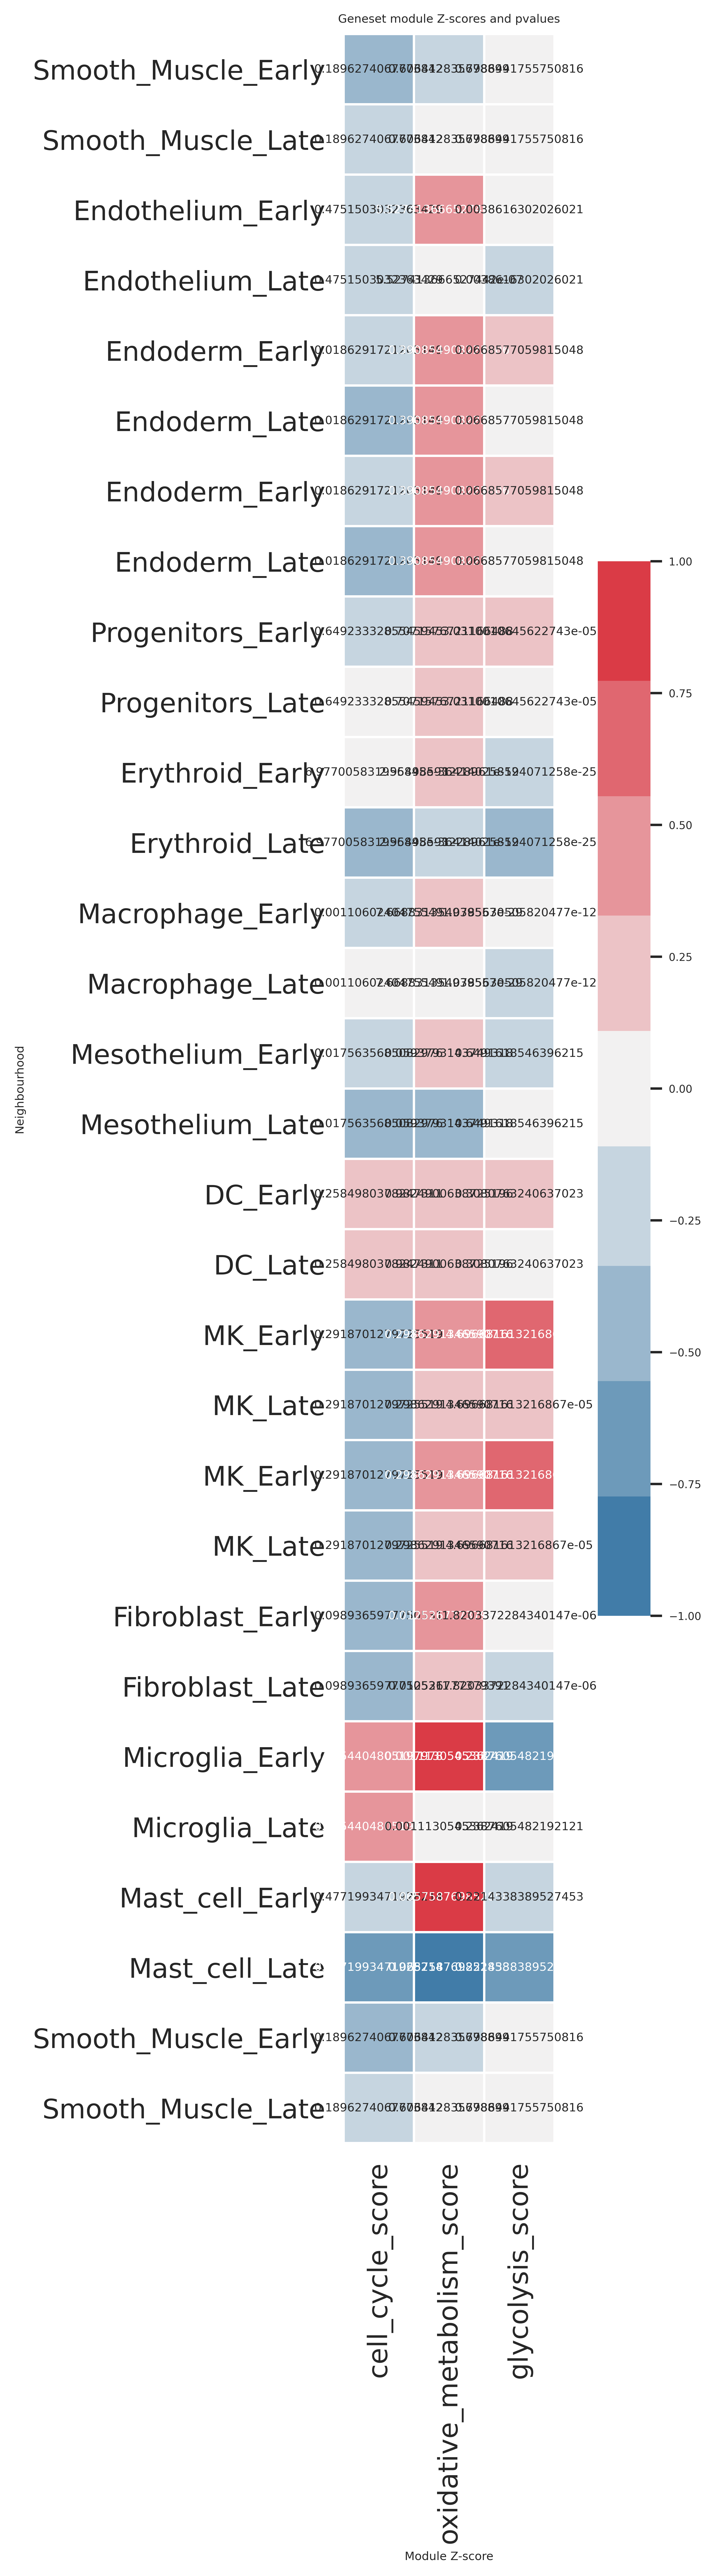

In [78]:
plt.figure(figsize=(8,20))
sns.set(font_scale=0.5)
pal = (sns.diverging_palette(240, 10, n=9))

annot = np.array(scores_pvals[list(scores_pvals.columns[scores_pvals.columns.str.contains('_score')])])
# g = sns.heatmap(scores_medians,  annot=True,vmin=-1, vmax=1, linewidths=1, center=0, cmap = pal, square=True, cbar_kws={"shrink": 0.5})
g = sns.heatmap(scores_medians,  annot=annot,vmin=-1, vmax=1, linewidths=1, center=0, cmap = pal, square=True, cbar_kws={"shrink": 0.5},fmt='')

plt.title('Geneset module Z-scores and pvalues', fontdict=None, loc='center')
plt.xticks(rotation=90,fontsize=14)
plt.yticks(rotation=0,fontsize=14)
plt.ylabel("Neighbourhood")
plt.xlabel("Module Z-score")
plt.savefig('./Milo_geneset_module_scores.pdf',dpi=300)

# V2 plot

In [71]:
gene_sets = {
'cell_cycle' : ['/nfs/team205/ig7/resources/GO-0022402_cell_cycle_genes.csv'],
'oxidative_metabolism' :['/nfs/team205/ig7/resources/GO-0045333_cell_respiration.csv'],
'glycolysis':['/nfs/team205/ig7/resources/HALLMARK_GLYCOLYSIS_M5937_.csv'],
            }

In [73]:
scores_totals

,cell_cycle_score,oxidative_metabolism_score,glycolysis_score,group
Wang_et_al_TTTACTGCATTCCTGC_2,0.171160,-0.219287,0.996298,Smooth_Muscle_Early
F37_Yolksac_Total_FCAImmP7504911_TCAGGTATCCAGAGGA,-0.492473,0.779960,0.184944,Smooth_Muscle_Late
F37_Yolksac_Total_FCAImmP7504912_AGCTCCTGTAGAGGAA,-0.202957,0.452694,0.127488,Smooth_Muscle_Late
F37_Yolksac_Total_FCAImmP7504912_GTCGTAAGTTCTCATT,-0.324382,1.000000,-0.069774,Smooth_Muscle_Late
F61_Yolksac_CD45P_FCAImmP7862088_TACGGTAAGGAGTTTA,-0.430583,-0.160667,-0.024916,Smooth_Muscle_Late
...,...,...,...,...
F80_Yolksac_CD45NAF_FCAImmP8096696_CCACGGAGTCTAGCGC,-0.717430,0.161061,-0.016584,Smooth_Muscle_Early
F80_Yolksac_CD45NAF_FCAImmP8096696_CTCGTACAGTTCGATC,-0.205336,0.494880,0.617388,Smooth_Muscle_Late
F80_Yolksac_CD45NAF_FCAImmP8096696_GCTGGGTTCAGTCCCT,-0.285823,0.801155,-0.060453,Smooth_Muscle_Late
F80_Yolksac_CD45NAF_FCAImmP8096696_GGGACCTCATGTTCCC,-0.560001,0.509198,-0.230360,Smooth_Muscle_Late


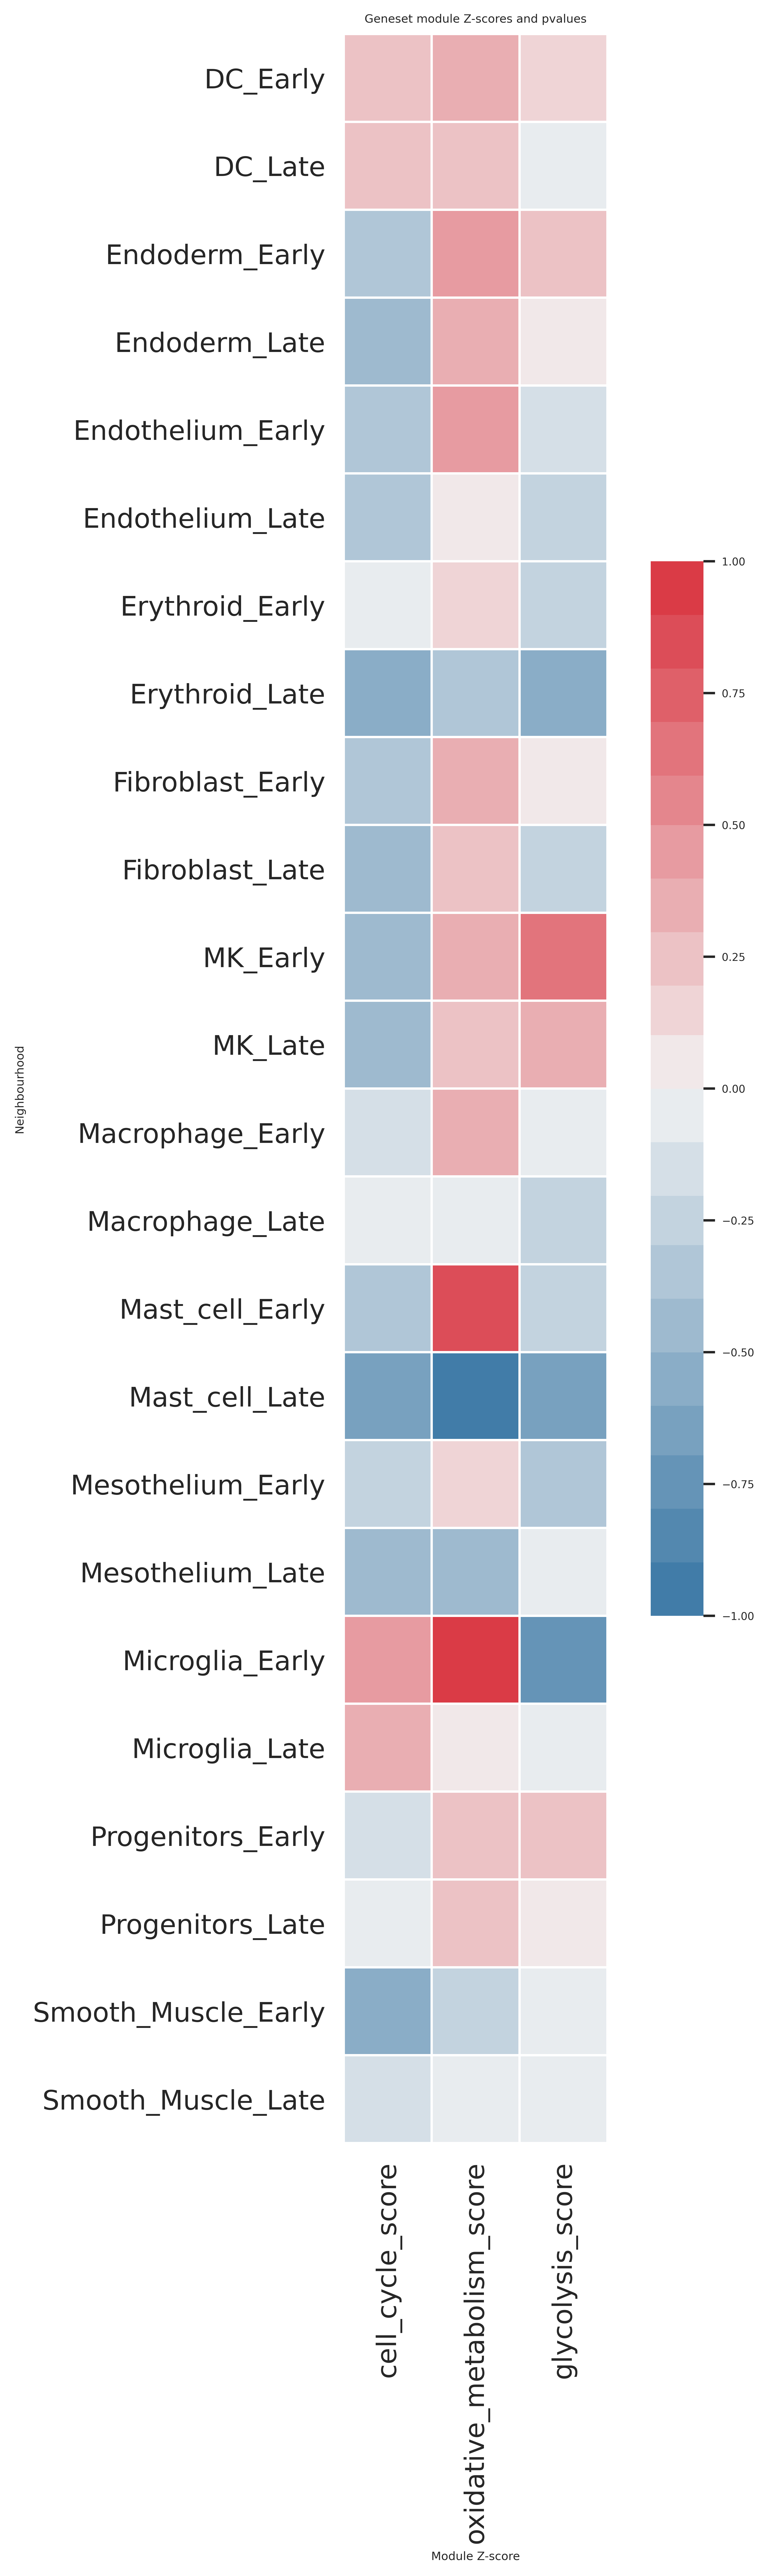

In [79]:
scores_medians = scores_totals.groupby('group').median()

plt.figure(figsize=(8,20))
sns.set(font_scale=0.5)
pal = (sns.diverging_palette(240, 10, n=20))

annot = np.array(scores_pvals[list(scores_pvals.columns[scores_pvals.columns.str.contains('_score')])])
# g = sns.heatmap(scores_medians,  annot=True,vmin=-1, vmax=1, linewidths=1, center=0, cmap = pal, square=True, cbar_kws={"shrink": 0.5})
g = sns.heatmap(scores_medians,  annot=False,vmin=-1, vmax=1, linewidths=1, center=0, cmap = pal, square=True, cbar_kws={"shrink": 0.5},fmt='')

plt.title('Geneset module Z-scores and pvalues', fontdict=None, loc='center')
plt.xticks(rotation=90,fontsize=14)
plt.yticks(rotation=0,fontsize=14)
plt.ylabel("Neighbourhood")
plt.xlabel("Module Z-score")
plt.savefig('./Milo_geneset_module_scores_no_annot.pdf',dpi=300)

In [97]:
scores_medians

,cell_cycle_score,oxidative_metabolism_score,glycolysis_score
Smooth_Muscle_Early,-0.527934,-0.219287,-0.016584
Smooth_Muscle_Late,-0.147065,-0.064022,-0.020441
Endothelium_Early,-0.312452,0.493266,-0.105220
Endothelium_Late,-0.305213,0.090619,-0.273157
Endoderm_Early,-0.308531,0.460828,0.242527
Endoderm_Late,-0.495186,0.355370,0.059466
Endoderm_Early,-0.308531,0.460828,0.242527
Endoderm_Late,-0.495186,0.355370,0.059466
Progenitors_Early,-0.137451,0.216819,0.280427
Progenitors_Late,-0.026321,0.258443,0.015290
